In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data = pd.read_csv('/content/gdrive/MyDrive/dataset/extractive.csv')

In [5]:
!pip install datasets==1.9
from datasets import Dataset

train_df = pd.read_csv('/content/gdrive/MyDrive/dataset/training/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/dataset/training/test.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/dataset/training/val.csv')
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 262 kB 30.7 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 96.4 MB/s 
     |████████████████████████████████| 212 kB 93.6 MB/s 


In [6]:
!pip install transformers==4.2.1
from transformers import BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 34.3 MB/s 
     |████████████████████████████████| 880 kB 58.4 MB/s 
     |████████████████████████████████| 2.9 MB 72.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=9c96b964b5ed45a410b3c59a41a77cd5d02fdc6aaeb62e6e40881cd6c2821ece
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [7]:
from transformers import BertModel, RobertaModel
import torch

model_bert = "indobenchmark/indobert-base-p1"
model_roberta = "cahya/roberta-base-indonesian-522M"
bert_base_cased = BertModel.from_pretrained(model_bert)  # Instantiate model using the trained weights
roberta_base_cased = RobertaModel.from_pretrained(model_roberta)  # Randomly initialize model, with the same size as the trained model

layers_to_replace = [1, 2, 3, 8]
for layer in layers_to_replace:
    roberta_base_cased.base_model.encoder.layer[layer] = bert_base_cased.base_model.encoder.layer[layer]

# Let's compare the key values of the attention layers to make sure they're the same
i = 0
for original_layer, new_layer in zip(roberta_base_cased.base_model.encoder.layer, bert_base_cased.base_model.encoder.layer):
    original_attention_key = original_layer.attention.self.key.weight
    new_attention_key = new_layer.attention.self.key.weight
    difference = (torch.max(torch.abs(original_attention_key - new_attention_key)).item())

    print(f"Layers {i} are {'not ' if difference else ''}the same.")
    i += 1

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/507M [00:00<?, ?B/s]

Layers 0 are not the same.
Layers 1 are the same.
Layers 2 are the same.
Layers 3 are the same.
Layers 4 are not the same.
Layers 5 are not the same.
Layers 6 are not the same.
Layers 7 are not the same.
Layers 8 are the same.
Layers 9 are not the same.
Layers 10 are not the same.
Layers 11 are not the same.


In [8]:
tokenizer_src = BertTokenizer.from_pretrained(model_bert)
tokenizer_src.bos_token = tokenizer_src.cls_token
tokenizer_src.eos_token = tokenizer_src.sep_token

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

In [9]:
from transformers import RobertaTokenizer

tokenizer_tgt = RobertaTokenizer.from_pretrained(model_roberta)
tokenizer_tgt.bos_token = tokenizer_tgt.cls_token
tokenizer_tgt.eos_token = tokenizer_tgt.sep_token

Downloading:   0%|          | 0.00/926k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

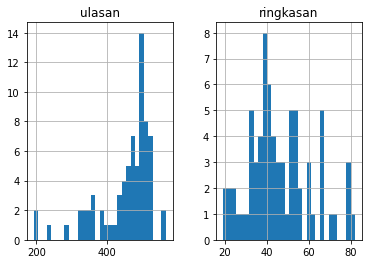

In [10]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['review_cln']:
      text_word_count.append(len(i.split()))

for i in data['abstractive']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'ulasan':text_word_count, 'ringkasan':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [11]:
max_ulasan = 512
print(max_ulasan)
max_ringkasan = max(summary_word_count)
print(max_ringkasan)

512
82


In [12]:
encoder_max_length = max_ulasan
decoder_max_length = max_ringkasan

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer_src(batch["review_sent"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer_tgt(batch["summary"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["labels"] = outputs.input_ids.copy()
  batch["decoder_attention_mask"] = outputs.attention_mask

  batch["labels"] = [
        [-100 if mask == 0 else token for mask, token in mask_and_tokens] for mask_and_tokens in [zip(masks, labels) for masks, labels in zip(batch["decoder_attention_mask"], batch["labels"])]
    ]
  
  assert all([len(x) == encoder_max_length for x in inputs.input_ids])
  assert all([len(x) == decoder_max_length for x in outputs.input_ids])
  return batch

In [13]:
batch_size=32

train_data = train_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    # remove_columns=["review", "extractive", "review_cln", "extractive_cln", "sent_tok", "review_key"]
)
val_data = val_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    # remove_columns=["review", "extractive", "review_cln", "extractive_cln", "sent_tok", "review_key"]
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [15]:
train_data[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

In [ ]:
# for layer in bert2gpt.encoder.encoder.layer[1:]:
#   for param in layer.parameters():
#     param.requires_grad = False

In [ ]:
# for layer in bert2gpt.encoder.encoder.layer:
#   for param in layer.parameters():
#     print(param.requires_grad)

In [ ]:
# bert2gpt

In [ ]:
# bert2gpt.config.decoder.eos_token_id

In [19]:
roberta_base_cased.config.decoder_start_token_id = tokenizer_tgt.bos_token_id
roberta_base_cased.config.eos_token_id = tokenizer_tgt.eos_token_id
roberta_base_cased.config.pad_token_id = tokenizer_tgt.pad_token_id
roberta_base_cased.config.max_length = 100
roberta_base_cased.config.min_length = 3
roberta_base_cased.config.no_repeat_ngram_size = 3
roberta_base_cased.early_stopping = True
roberta_base_cased.length_penalty = 2.0
roberta_base_cased.num_beams = 8

In [20]:
!pip install rouge_score
from datasets import load_metric

rouge = load_metric("rouge")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=1b8febcea6b1609bc7ccdf9562eb1ea0bb0c1e551f94b2225bd4f5440279bb1a
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score


Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [21]:
def rouge_matrix(pred, ref):
  result = rouge.compute(predictions=pred, references=ref)
  rouge1 = result['rouge1'].mid
  rouge2 = result['rouge2'].mid
  rougeL = result['rougeL'].mid

  return {
      "rouge1_fmeasure": round(rouge1.fmeasure, 4),
      "rouge2_fmeasure": round(rouge2.fmeasure, 4),
      "rougeL_fmeasure": round(rougeL.fmeasure, 4),
  }

In [22]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer_tgt.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer_tgt.pad_token_id
    label_str = tokenizer_tgt.batch_decode(labels_ids, skip_special_tokens=True)

    result = rouge_matrix(pred_str, label_str)

    return result

In [23]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # fp16=True, 
    output_dir="./",
    do_train=True,
    do_eval=True,
    logging_steps=50,  
    save_steps=32, 
    # warmup_steps=50,  
    # max_steps=1500, # delete for full training
    num_train_epochs = 128, #TRAIN_EPOCHS
    # save_total_limit=1,
)

In [24]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=roberta_base_cased,
    tokenizer=tokenizer_tgt,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

OutOfMemoryError: ignored

In [ ]:
trainer.save_model('/content/gdrive/MyDrive/Colab Notebooks/tesis/bert2gpt-sep')

In [ ]:
model = EncoderDecoderModel.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/tesis/bert2gpt-sep')

In [ ]:
test_data = Dataset.from_pandas(test_df)

batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer_src(batch["review"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    outputs = model.generate(input_ids, max_length=decoder_max_length, attention_mask=attention_mask, num_beams=10,
                                repetition_penalty=5.0, num_return_sequences=1)

    # all special tokens including will be removed
    output_str = tokenizer_tgt.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [ ]:
results = test_data.map(generate_summary, batched=True, batch_size=batch_size)
pred_str = results["pred"]
label_str = results["summary"]

rouge_output = rouge_matrix(pred_str, label_str)
print(rouge_output)

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:absl:Using default tokenizer.


{'rouge1_fmeasure': 0.2674, 'rouge2_fmeasure': 0.0531, 'rougeL_fmeasure': 0.1677}


In [ ]:
for i in range(len(test_data)):
    print('ulasan: ',test_data[i]["review"])
    print('ringkasan: ',label_str[i])
    print('prediksi: ',pred_str[i])
    print("===================")

ulasan:  selalu rame pas sarapan dan makan siang. soto ayam bening porsinya pas tdk terlalu kecil dengan berbagai pilihan lauk tersedia di meja. salah satu restoran soto yang kami coba di solo. tambahan lauk ada sate paru sate usus perkedel ote dl dengan harga mulai rp. sotonya sih biasa minimalis cokotan seperti sate paru otak goreng sate kikil empal dan rombongan kolesterol lainnya bikin soto jadi lebih nikmat.
ringkasan:  Rumah makan soto yang menjadi langganan presiden pak jokowi. Lokasi dekat dengan alun-alun. Sotonya enak ditambah lauk yang bermacam-macam seperti sate paru menambah kenikmatan. Harga terjangkau. Tempat selalu ramai sehingga sulit untuk mencari meja dan kursi. Namun semua teratasi dengan pelayanan staf yang tanggap dan ramah.
prediksi:  Jenis makanan sangat variatif mulai dari sunda, eropa, dan asia timur. Ada beberapa makanan yang kurang enak yaitu steak dan sushi. Kedua makanan itu keras. Minuman kopi, teh, dan juice juga variatif. Pengunjung dapat melihat pemand

In [ ]:
test_data = Dataset.from_pandas(test_df)

batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary_beam(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer_src(batch["proposed_extractive"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    outputs = model.generate(input_ids, max_length=decoder_max_length, attention_mask=attention_mask, num_beams=10)

    # all special tokens including will be removed
    output_str = tokenizer_tgt.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [ ]:
resultsb = test_data.map(generate_summary_beam, batched=True, batch_size=batch_size, remove_columns=["review", "extractive", "proposed_extractive", "extractive_cln", "sent_tok", "review_key"])
pred_strb = resultsb["pred"]
label_strb = resultsb["abstractive"]

rouge_output = rouge_matrix(pred_strb, label_strb)
print(rouge_output)

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:absl:Using default tokenizer.


{'rouge1_fmeasure': 0.2582, 'rouge2_fmeasure': 0.0467, 'rougeL_fmeasure': 0.1524}


In [ ]:
rslt.to_excel('/content/gdrive/MyDrive/Colab Notebooks/result.xlsx')

In [ ]:
batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary(text):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer_src(text, padding="max_length", truncation=True, max_length=70, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer_tgt.batch_decode(outputs, skip_special_tokens=True)

    

    return output_str

# results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["ulasan"])

# pred_str = results["pred"]
# label_str = results["ringkasan"]

# rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
x = generate_summary('Hotelnya dekat banget sama kuta, nyaman dan lobbynya bagus.')
print(x)

['lokasi strategis dan hotel nyaman']


In [ ]:
print(rouge_output)

Score(precision=0.0, recall=0.0, fmeasure=0.0)


In [ ]:
test_data = Dataset.from_pandas(test_df)
test_data = test_data.select(range(30))

max_ulasan_len=70
max_ringkasan_len=14

def generate_summary(batch):
    inputs = tokenizer(batch["ulasan"], padding="max_length", truncation=True, max_length=max_ulasan_len, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    batch["pred"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

results = test_data.map(generate_summary, batched=True, batch_size=4, remove_columns=["ulasan"])

pred_str = results["pred"]
label_str = results["ringkasan"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid
print(rouge_output)

  0%|          | 0/8 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 70 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Score(precision=0.003138943460670141, recall=0.03611111111111111, fmeasure=0.005720116401230952)


In [ ]:
device = torch.device("cpu")
def train(
    args,
    model: EncoderDecoderModel,
    train_dataloader,
    eval_dataloader,
    optimizer,
    scheduler,
    src_tokenizer,
    tgt_tokenizer,
):
    eval_bleu = -1
    for epoch in range(args.nepoch):
        step = 0
        total_batch = train_dataloader.__len__()
        for data in train_dataloader:
            (
                input_ids,
                attention_mask,
                decoder_input_ids,
                decoder_attention_mask,
                labels,
            ) = data
            outputs = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=decoder_attention_mask.to(device),
                labels=labels.to(device),
                return_dict=True,
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
            model.zero_grad()
            if args.ngpu > 1:
                reduced_loss = reduce_tensor(loss).cpu().item()
            else:
                reduced_loss = loss.cpu().item()
            if local_rank == 0 or local_rank == -1:
                lr, finetune_lr = scheduler.get_lr()[0], scheduler.get_lr()[1]
                print(
                    "\rstep:{}/{}, bleu:{} loss:{}, lr:{}, ft.lr:{}".format(
                        step,
                        total_batch,
                        round(eval_bleu, 4),
                        round(reduced_loss, 4),
                        round(lr, 6),
                        round(finetune_lr, 6),
                    ),
                    end="",
                )
                writer.add_scalar("loss", reduced_loss, int(step * (1 + epoch)))
                writer.add_scalar("lr", lr, int(step * (1 + epoch)))
                writer.add_scalar("finetune_lr", finetune_lr, int(step * (1 + epoch)))
                if step % args.save_step == 0 or step % total_batch == 0:
                    eval_bleu = eval(
                        model, eval_dataloader, tgt_tokenizer, args.max_src_len
                    )
                    writer.add_scalar("bleu", eval_bleu, int(step * (1 + epoch)))
                    model_to_save = model.module if hasattr(model, "module") else model
                    save_model(
                        args,
                        model_to_save,
                        optimizer,
                        src_tokenizer,
                        tgt_tokenizer,
                        step,
                        epoch,
                        eval_bleu,
                        reduced_loss,
                    )


In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    if token_ids_1 is None:
        return [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    bos = [self.bos_token_id]
    eos = [self.eos_token_id]
    return bos + token_ids_0 + eos + token_ids_1 + eos

In [ ]:
import types

tgt_tokenizer.add_special_tokens(
            {"bos_token": "[BOS]", "eos_token": "[EOS]", "pad_token": "[PAD]"}
        )
tgt_tokenizer.build_inputs_with_special_tokens = types.MethodType(
            build_inputs_with_special_tokens, tgt_tokenizer
        )

In [ ]:
from transformers import (
    BertGenerationConfig,
    BertGenerationEncoder,
    BertTokenizer,
    EncoderDecoderModel,
    EncoderDecoderConfig,
    BertLMHeadModel,
    GPT2Tokenizer,
    Trainer,
    TrainingArguments,
    get_cosine_schedule_with_warmup,
)

encoder = BertGenerationEncoder.from_pretrained("indolem/indobert-base-uncased")
decoder = BertLMHeadModel.from_pretrained(
            "indolem/indobert-base-uncased", add_cross_attention=True, is_decoder=True
        )
decoder.resize_token_embeddings(len(tgt_tokenizer))
decoder.config.bos_token_id = tgt_tokenizer.bos_token_id
decoder.config.eos_token_id = tgt_tokenizer.eos_token_id
decoder.config.vocab_size = len(tgt_tokenizer)
decoder.config.add_cross_attention = True
decoder.config.is_decoder = True

model_config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder.config, decoder.config)
model = EncoderDecoderModel( encoder=encoder, decoder=decoder, config=model_config)

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertGenerationEncoder: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'bert.pooler.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'bert.pooler.dense.bias', 'bert.embeddings.token_type_embeddings.weight']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel w